In [1]:
#setup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import matplotlib as mpl
import itertools as it
mpl.rcParams['pdf.fonttype'] = 42


def get_colormap(colors, N = 256):
    return clr.LinearSegmentedColormap.from_list('custom', colors, N=N) if len(colors) > 1 else plt.get_cmap(*colors)


def get_bin_index(site, leftBound, rightBound, binsize):
    binbounds = np.arange(leftBound, rightBound, binsize)
    return len(np.where(binbounds < site)[0]) \
           if not (site < binbounds[0] or site > binbounds[-1]) \
           else None


def annotate_contacts(ax, 
                      contacts, 
                      r = 2.5, 
                      linestyle = '--', 
                      edgecolor = 'k',
                      mirror_horizontal = False):
    t = np.array([[1, 0.5], [-1, 0.5]]) if mirror_horizontal else np.array([[-1, 0.5], [1, 0.5]])
    
    for x, y in contacts:
        M = np.array([[x, y]])
        M = np.dot(M, t)
        ax.add_patch(patches.Circle((M[:, 1], M[:, 0]), 
                                    radius = r,
                                    fill = False,
                                    ls = linestyle,
                                    edgecolor = edgecolor,
                                    zorder = 3))

igh = (114435000, 114669000)
interacting_regions = pd.read_table('../resource/regions_of_interest_mm9.tsv', sep='\t', names=['i', 0, 1], index_col='i').transpose()
interacting_regions


i,3PrZoom,3CBE,3CBE3RR,3CBEhs4,3CBE3pr3b,3RR+,3RR,hs4,hs4_capture,hs3b+4,...,noise2,noise1,muDelta,mu+,SmCm,mu,Sm,Emu_capture,Em,Emu-IgG1
0,114435000,114453981,114453981,114453981,114453981,114463472,114466175,114466175,114466346,114466175,...,114606000,114630000,114652483,114655000,114657164,114657164,114662156,114664945,114665493,114665493
1,114504000,114463472,114492784,114466981,114469927,114492784,114492784,114466981,114466563,114471105,...,114622000,114646000,114666183,114666183,114664070,114664070,114664070,114665103,114665940,114577464


In [2]:
# reading in samplenames and subset for IgG1 samples of mouse
samplenames = pd.read_csv('../resource/sampleinfo_TriC17mm9.tsv', 
                          sep = '\t', 
                          header = None, 
                          names = ['name', 'capture', 'genome'])

samplenames = samplenames.loc[samplenames.capture.str.startswith('IgG3_pool_capture') & 
                              (samplenames.genome == 'mm9') &
                              samplenames.name.str.startswith(tuple(['TriC17_priB_B18AIDKO_LPS_igg3']))] \
                         .reset_index(drop = True)

samplenames


,name,capture,genome
0,TriC17_priB_B18AIDKO_LPS_igg3_d3_1,IgG3_pool_capture,mm9
1,TriC17_priB_B18AIDKO_LPS_igg3_d0_3,IgG3_pool_capture,mm9
2,TriC17_priB_B18AIDKO_LPS_igg3_d3_2,IgG3_pool_capture,mm9
3,TriC17_priB_B18AIDKO_LPS_igg3_d0_2,IgG3_pool_capture,mm9
4,TriC17_priB_B18AIDKO_LPS_igg3_d0_1,IgG3_pool_capture,mm9
5,TriC17_priB_B18AIDKO_LPS_igg3_d3_3,IgG3_pool_capture,mm9


In [4]:
# reading matrices and setting capture bins to 0
mats = {}
cbinidx = get_bin_index(interacting_regions['Emu_capture'][0], igh[0], igh[1], 1000)
for name in samplenames.name:
    m = np.loadtxt(f'../TriCplots/TriC17_mapq20/{name}_TriC_interactions_1000_RAW.tab',
                   delimiter = '\t')
    m[cbinidx, :] = 0
    m[:, cbinidx] = 0
    mats[name] = m


In [5]:
def collect_contacts(m, contact_regionX, contact_regionY, total_region, binsize = 1000, axis=1):
    idxs = []
    for contact_region in [contact_regionX, contact_regionY]:
        start = contact_region[0]
        end = contact_region[1]
        startbin = get_bin_index(start, total_region[0], total_region[1], binsize)
        endbin = get_bin_index(end, total_region[0], total_region[1], binsize) + 1

        idxs.append((startbin, endbin))
            
    contactReg = m[idxs[0][0]: idxs[0][1], idxs[1][0]: idxs[1][1]]
    contactTrack = contactReg.sum(axis=axis)
    
    return contactTrack, idxs

In [6]:
x = np.matrix([[1, 2, 3], [4, 3, 2]])
x.sum(axis = 1)

matrix([[6],
        [9]])

In [7]:
region1 = '3PrZoom'
region2 = 'mu+'

contact_tracks = []
for sample, capture in zip(samplenames.name, samplenames.capture):
    if sample[-2] == '+': # Exeption for TriC12-13 because replicates 1 and 3 are already pooled for d0 samples (look at names)
        n = 1
        name = sample[:-4]
    else: 
        nameparts = sample.split('_')
        n = int(nameparts[-1])
        name = nameparts[-2]
    m = mats[sample]

    contact_track, idxs = collect_contacts(m, 
                                        interacting_regions[region1], 
                                        interacting_regions[region2], 
                                        igh,
                                        binsize=1000)
    contact_tracks.append([name, n, capture, region1, region2, contact_track])
        
contact_tracks = pd.DataFrame(contact_tracks, columns = ['sample', 'replicate', 'capture', 'region1', 'region2', 'track'])
contact_tracks = contact_tracks.sort_values(['sample', 'replicate'], ignore_index=True)
contact_tracks.loc[:5] = contact_tracks[:6].sort_values('sample', ascending=False, ignore_index=True)

contact_tracks

,sample,replicate,capture,region1,region2,track
0,d3,1,IgG3_pool_capture,3PrZoom,mu+,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,d3,2,IgG3_pool_capture,3PrZoom,mu+,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,d3,3,IgG3_pool_capture,3PrZoom,mu+,"[0.0, 0.0, 0.0, 0.0, 0.0, 113.4, 0.0, 0.0, 0.0..."
3,d0,1,IgG3_pool_capture,3PrZoom,mu+,"[0.0, 0.0, 0.0, 0.0, 67.1, 0.0, 0.0, 0.0, 0.0,..."
4,d0,2,IgG3_pool_capture,3PrZoom,mu+,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,d0,3,IgG3_pool_capture,3PrZoom,mu+,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [8]:
# annotation function  
def add_annotation_line2D(ax, annotation, increment, xmin, xmax, flipped, alternating=False, mirror_horizontal=False):
    tab = pd.read_csv(annotation, sep='\t')
    subset = tab.loc[(tab.start > xmin) & (tab.end < xmax), :]
    
    plt.rcParams['font.size'] = 15

    if flipped:
        for i, locus in subset.iterrows():
            start, end = locus['start'], locus['end']
            x1 = xmin if end < xmin else (xmax - end) * increment
            x2 = xmax if end > xmax else (xmax - start) * increment

            color = 'black' if pd.isna(locus['color']) else locus['color']
            alpha = 1 if pd.isna(locus['alpha']) else float(locus['alpha'])

            if alternating:
                if i % 2 == 0:
                    ax.add_line(Line2D([x1, x2], [0.425, 0.425], lw=5, solid_capstyle='butt', color=color, alpha=alpha))

                else:
                    ax.add_line(Line2D([x1, x2], [0.575, 0.575], lw=5, solid_capstyle='butt', color=color, alpha=alpha))

            else:
                if not mirror_horizontal:
                    ax.add_line(Line2D([x1, x2], [0.75, 0.75], lw=5, solid_capstyle='butt', color=color, alpha=alpha))
                else:
                    ax.add_line(Line2D([x1, x2], [0.25, 0.25], lw=5, solid_capstyle='butt', color=color, alpha=alpha))


            if alternating:
                if i % 2 == 0:
                    ax.text((x2 - x1) / 2 + x1, 0.325, 
                    '' if pd.isna(locus['name']) else locus['name'],
                    ha='center' if pd.isna(locus['pos']) else locus['pos'],
                    va='top')

                else:
                    ax.text((x2 - x1) / 2 + x1, 0.675, 
                    '' if pd.isna(locus['name']) else locus['name'],
                    ha='center' if pd.isna(locus['pos']) else locus['pos'],
                    va='bottom')

            else:
                if not mirror_horizontal:
                    ax.text((x2 - x1) / 2 + x1, 0.5, 
                    '' if pd.isna(locus['name']) else locus['name'],
                    ha='center' if pd.isna(locus['pos']) else locus['pos'],
                    va='top')
                else:
                    ax.text((x2 - x1) / 2 + x1, 0.5, 
                    '' if pd.isna(locus['name']) else locus['name'],
                    ha='center' if pd.isna(locus['pos']) else locus['pos'],
                    va='bottom')

    else:
        for i, locus in subset.iterrows():
            start, end = locus['start'], locus['end']
            x1 = xmin if start < xmin else (start - xmin) * increment
            x2 = xmax if end > xmax else (end - xmin) * increment

            color = 'black' if pd.isna(locus['color']) else locus['color']
            alpha = 1 if pd.isna(locus['alpha']) else float(locus['alpha'])

            if alternating:
                if i % 2 == 0:
                    ax.add_line(Line2D([x1, x2], [0.425, 0.425], lw=5, solid_capstyle='butt', color=color, alpha=alpha))

                else:
                    ax.add_line(Line2D([x1, x2], [0.575, 0.575], lw=5, solid_capstyle='butt', color=color, alpha=alpha))

            else:
                if not mirror_horizontal:
                    ax.add_line(Line2D([x1, x2], [0.75, 0.75], lw=5, solid_capstyle='butt', color=color, alpha=alpha))
                else:
                    ax.add_line(Line2D([x1, x2], [0.25, 0.25], lw=5, solid_capstyle='butt', color=color, alpha=alpha))


            if alternating:
                if i % 2 == 0:
                    ax.text((x2 - x1) / 2 + x1, 0.325, 
                    '' if pd.isna(locus['name']) else locus['name'],
                    ha='center' if pd.isna(locus['pos']) else locus['pos'],
                    va='top')

                else:
                    ax.text((x2 - x1) / 2 + x1, 0.675, 
                    '' if pd.isna(locus['name']) else locus['name'],
                    ha='center' if pd.isna(locus['pos']) else locus['pos'],
                    va='bottom')

            else:
                if not mirror_horizontal:
                    ax.text((x2 - x1) / 2 + x1, 0.5, 
                    '' if pd.isna(locus['name']) else locus['name'],
                    ha='center' if pd.isna(locus['pos']) else locus['pos'],
                    va='top')
                else:
                    ax.text((x2 - x1) / 2 + x1, 0.5, 
                    '' if pd.isna(locus['name']) else locus['name'],
                    ha='center' if pd.isna(locus['pos']) else locus['pos'],
                    va='bottom')
    plt.rcParams['font.size'] = 20

def plot_annotation(ax,
                    track,
                    ylabel,
                    alternating,
                    ylim,
                    number_of_bins,
                    start,
                    end,
                    mirror_horizontal=False,
                    flipped=True):
    increment = number_of_bins / (end - start)
    ax.set_ylim(bottom=ylim[0], top=ylim[1])
    ax.set_yticks([])
    ax.set_ylabel(ylabel, fontsize=15)
    ax.spines['top'].set_visible(False)

    add_annotation_line2D(ax, track, increment, start, end, flipped, alternating, mirror_horizontal)

    ax.set_xlim((0, number_of_bins))
    ax.get_xaxis().set_ticks([])
    # ax.set_xticks(range(start, end, increment))

    return ax

In [9]:
colordict = {'KO': 'black',
			'ctrl': 'red',
			'd3' : 'black', 
			'd2': 'violet',
			'd0': 'red',
			'-TPL': 'black',
			'+1hTPL': 'violet',
			'+3hTPL': 'red'
}

def plot_track(ax,
			trackdf,
			flipped,
			pool=True,
			capturebins=None,
			ylabel=None,
			xlabel=None,
			xticks=False,
			legend=True,
			spines=False):
	ax.spines['bottom'].set_visible(spines)
	ax.get_xaxis()

	for (condition, group) in trackdf.groupby('sample'):
		if pool:
			track = group['track'].mean()
			if flipped:
				track = np.flip(track)
			ax.plot(track, color = colordict[condition], label = condition)
		else:
			for i, l in group.iterrows():
				track = l['track']
				if flipped:
					track = np.flip(track)
				ax.plot(track, color = colordict[condition], label = f'{condition} repl. {str(l.replicate)}')
		
	if legend: ax.legend()
	
	return ax

In [10]:
increment = 69 / (114504000 - 114435000)
increment
# list(range(114435000, 114504000, increment))


0.001

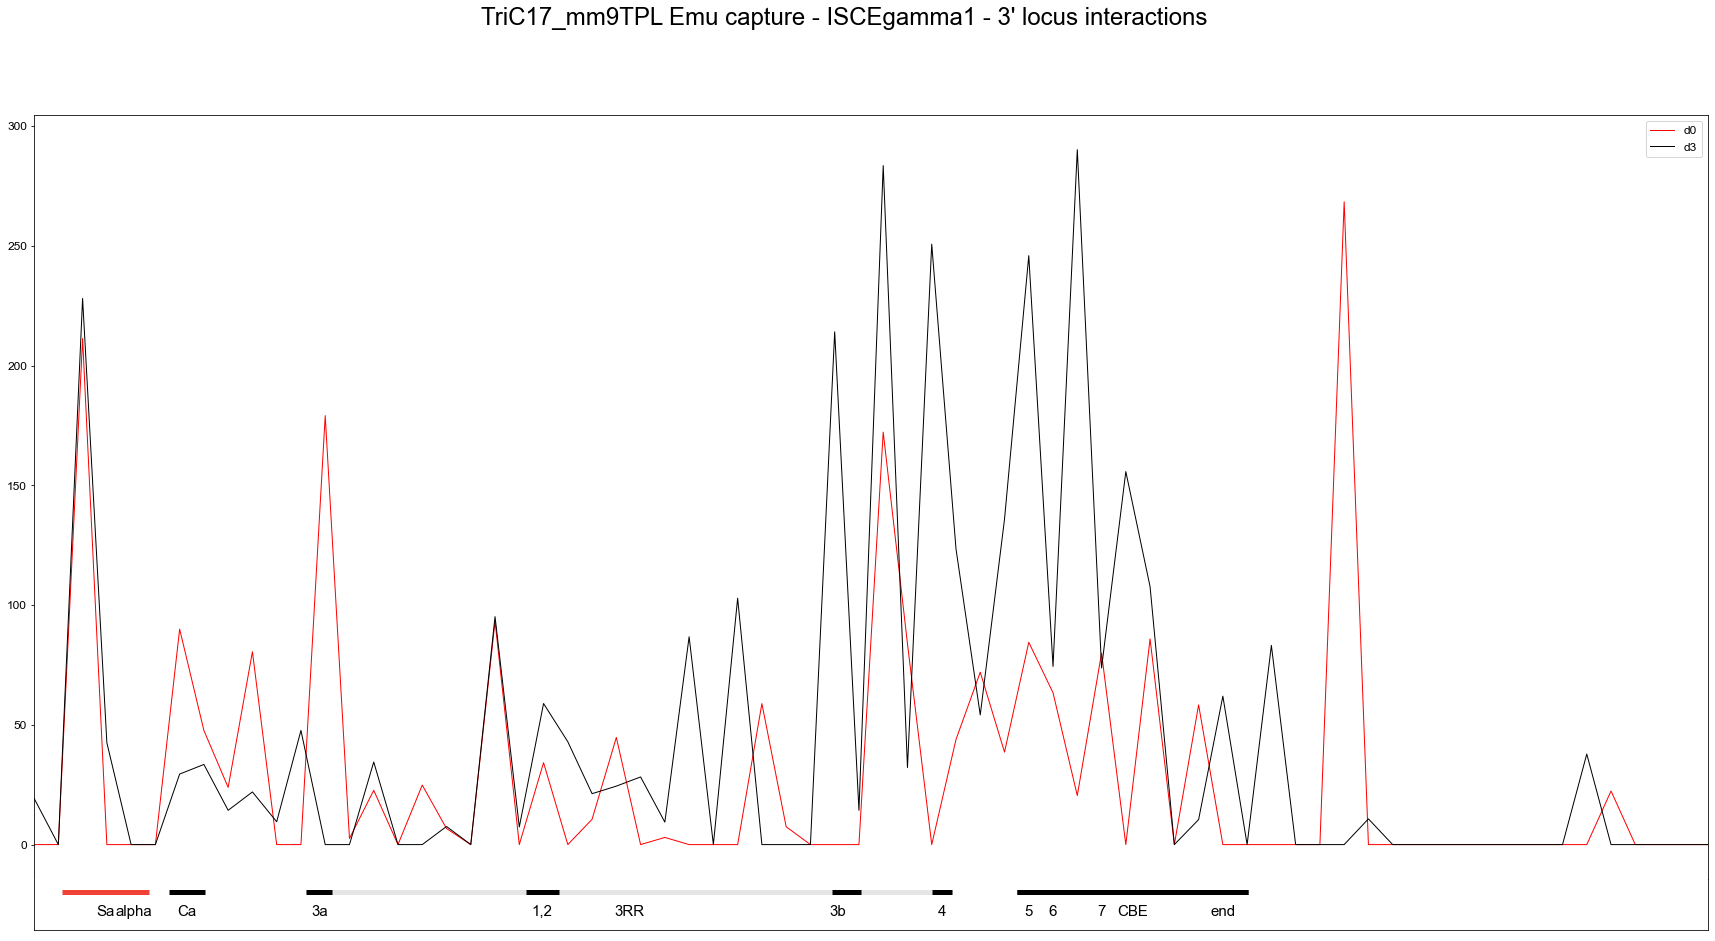

In [11]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 1
fig = plt.figure(figsize=(30,15))
gs = fig.add_gridspec(2, 1, hspace = 0, height_ratios = [15, 1])
(ax1, ax2) = gs.subplots(sharex = 'col')

plot_track(ax1, contact_tracks, flipped = True)
plot_annotation(ax2, '../resource/mm9_vdj_genes_flipped_zoom.sort.bed', None, False, (0, 1), 69, 114435000, 114504000)

fig.suptitle("TriC17_mm9LPS IgG3 pool capture - mu - 3' locus interactions")
plt.show()

fig.savefig('../plots/TriC17/TriC17_mm9LPS_RegOfInterest_IgG3poolCap_3prHist.pdf')


IgG3_pool_capture_d3 v.s. IgG3_pool_capture_d0: t-test independent samples with Bonferroni correction, P_val=8.636e-02 stat=2.263e+00


Text(0.5, 0.98, 'TriC17_mm9TPL_RegOfInterest_EmuCap_3prHist')

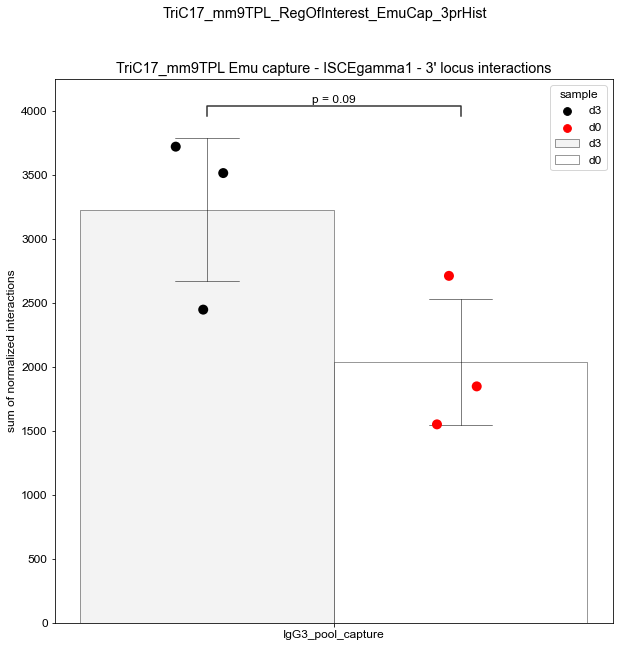

In [15]:
import seaborn as sns
import statannot

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 0.5

contact_tracks['tracksum'] = contact_tracks.track.apply(lambda x: np.sum(x))

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
sns.barplot(ax=ax, data=contact_tracks, x='capture', y='tracksum', hue='sample', ci='sd', color='white', linewidth=0.5, edgecolor='black', 
	errcolor='black', errwidth=0.5, capsize=0.1, alpha=0.8)
sns.stripplot(ax=ax, data=contact_tracks, x='capture', y='tracksum', hue='sample', dodge=True, size=10,
	palette=['black', 'red'])

boxlist = [] # list with pairs for statistical significance test
for cap in contact_tracks.capture.unique():
	boxlist = boxlist + [((cap, contact_tracks['sample'].unique()[0]), (cap, contact_tracks['sample'].unique()[1]))]
statannot.add_stat_annotation(ax=ax, data=contact_tracks, x='capture', y='tracksum', hue='sample', box_pairs=boxlist, test='t-test_ind', text_format='simple', verbose=2)

handles, labels = ax.get_legend_handles_labels()
ax.set_ylabel('sum of normalized interactions')
ax.set_xlabel("")
ax.set_title("TriC17_mm9LPS IgG3pool capture - mu - 3' locus interactions")
fig.suptitle('TriC17_mm9LPS_RegOfInterest_IgG3poolCap_3prHist')
# fig.savefig('../plots/TriC17/TriC17_mm9TPL_RegOfInterest_EmuCap_3prHist_stats.pdf')
